# Aplicação de Modelos de Regressão

Neste Notebook, iremos importar os dados já limpados/filtrados em etapas anteriores e iremos aplicar diversos algoritmos visando ajustar uma boa regressão que nos ajude a prever as velocidades dos ventos de um determinado evento (Tropical Storm ou Hurricane) ou a duração dos mesmos.
Algumas pequenas transformações serão necessárias para ajuste das variáveis preditoras a serem consideradas em cada modelo.

## Instalação e Importação de Pacotes

Os códigos de instalação abaixo estão comentados. Na primeira utilização do Notebook, pode-se descomentá-los para instalar os pacotes que ainda não estejam instalados no computador que se esteja utilizando.
Além disso, alguns pacotes abaixo são para utilização nos demais notebooks do projeto.

In [1]:
'''
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6
'''

'\n!apt-get install libgeos-3.5.0\n!apt-get install libgeos-dev\n!pip install https://github.com/matplotlib/basemap/archive/master.zip\n!pip install pyproj==1.9.6\n'

In [2]:
'''
!pip install netcdf4
'''

'\n!pip install netcdf4\n'

In [3]:
'''
Dependencies for Tropycal Package: https://pypi.org/project/tropycal/
matplotlib >= 2.2.2
numpy >= 1.14.3
scipy >= 1.1.0
pandas >= 0.23.0
geopy >= 1.18.1
xarray >= 0.10.7
networkx >= 2.0.0
requests >= 2.22.0
To fully leverage tropycal's plotting capabilities, it is strongly recommended to have cartopy >= 0.17.0 installed.

!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scipy
#!pip uninstall geopy
!pip install geopy
!pip install xarray
!pip install networkx
!pip install requests
!pip install proj
!pip install proj-data
!pip install geos
#!pip uninstall cartopy
!apt-get -qq install python-cartopy python3-cartopy
!pip install cartopy
!pip install tropycal
#!pip freeze
'''

"\nDependencies for Tropycal Package: https://pypi.org/project/tropycal/\nmatplotlib >= 2.2.2\nnumpy >= 1.14.3\nscipy >= 1.1.0\npandas >= 0.23.0\ngeopy >= 1.18.1\nxarray >= 0.10.7\nnetworkx >= 2.0.0\nrequests >= 2.22.0\nTo fully leverage tropycal's plotting capabilities, it is strongly recommended to have cartopy >= 0.17.0 installed.\n\n!pip install numpy\n!pip install pandas\n!pip install matplotlib\n!pip install scipy\n#!pip uninstall geopy\n!pip install geopy\n!pip install xarray\n!pip install networkx\n!pip install requests\n!pip install proj\n!pip install proj-data\n!pip install geos\n#!pip uninstall cartopy\n!apt-get -qq install python-cartopy python3-cartopy\n!pip install cartopy\n!pip install tropycal\n#!pip freeze\n"

In [4]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as c
#from mpl_toolkits.basemap import Basemap,shiftgrid
import pandas as pd
import netCDF4 as nc
from itertools import chain
from netCDF4 import Dataset
from netCDF4 import date2index
from datetime import datetime
import scipy
import geopy
import xarray
import networkx
import requests
import cartopy
import tropycal

import tropycal.tracks as tracks
import tropycal.tornado as tornado
import datetime as dt

In [5]:
import statsmodels.api as sm
from statsmodels.api import OLS
'''
# Modelos para Testes Futuros de Regressão
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

import math
from scipy.special import gamma

import seaborn as sns
sns.set()

alpha = 0.5

from sklearn import preprocessing
'''

'\n# Modelos para Testes Futuros de Regressão\nfrom sklearn.decomposition import PCA\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.linear_model import LogisticRegressionCV\nfrom sklearn.discriminant_analysis import LinearDiscriminantAnalysis\nfrom sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis\nfrom sklearn.preprocessing import PolynomialFeatures\nfrom sklearn.neighbors import KNeighborsClassifier\nfrom sklearn.model_selection import cross_val_score\nfrom sklearn.metrics import accuracy_score\nfrom sklearn.model_selection import KFold\n\nimport math\nfrom scipy.special import gamma\n\nimport seaborn as sns\nsns.set()\n\nalpha = 0.5\n\nfrom sklearn import preprocessing\n'

In [6]:
#import csv
from pandas.plotting import scatter_matrix

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn import svm
#from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import GroupKFold
'''
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
'''

'\nfrom sklearn.datasets import make_friedman2\nfrom sklearn.gaussian_process import GaussianProcessRegressor\nfrom sklearn.gaussian_process.kernels import DotProduct, WhiteKernel\n'

# Carregamento e Preparação dos Dados

In [7]:
#Importação dos dados previamente estruturados
data_atl_merged = pd.read_csv('data/data_atl_merged2.csv')

In [8]:
print(data_atl_merged.columns)
data_atl_merged.head()

Index(['ID', 'Name', 'Date', 'Time', 'Event', 'Status', 'Latitude',
       'Longitude', 'Maximum Wind', 'Minimum Pressure', 'Date_c', 'Year',
       'Month', 'Day', 'Latitude_c', 'Longitude_c', 'Duration', 'sst', 'rhum',
       'wspd', 'slp', 'cldc'],
      dtype='object')


,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Month,Day,Latitude_c,Longitude_c,Duration,sst,rhum,wspd,slp,cldc
0,AL011951,UNNAMED,1951-01-02,1200,NaN,EX,30.5,-58.0,50,-999,...,1,2,30.5,-58.0,10,12.371029,72.457094,72.457094,1027.446055,5.219256
1,AL011951,UNNAMED,1951-01-02,1800,NaN,EX,29.9,-56.8,45,-999,...,1,2,29.9,-56.8,10,16.217764,80.423854,80.423854,1022.672978,5.756614
2,AL011951,UNNAMED,1951-01-03,0,NaN,EX,29.0,-55.7,45,-999,...,1,3,29.0,-55.7,10,15.491124,81.121590,81.121590,1023.151909,5.782474
3,AL011951,UNNAMED,1951-01-03,600,NaN,EX,27.5,-54.8,45,-999,...,1,3,27.5,-54.8,10,22.268075,84.264761,84.264761,1019.325138,5.651842
4,AL011951,UNNAMED,1951-01-03,1200,NaN,EX,26.5,-54.5,45,-999,...,1,3,26.5,-54.5,10,22.336746,84.458617,84.458617,1019.305866,5.645406


In [9]:
y_train_mw = data_atl_merged['Maximum Wind']
y_train_mp = data_atl_merged['Minimum Pressure']
y_train_mp[y_train_mp < 0] = -1
y_train_dur = data_atl_merged['Duration']
X_train = data_atl_merged.drop(['ID', 'Name', 'Date', 'Time', 'Event', 'Status', 'Maximum Wind', 'Minimum Pressure', 'Date_c', 'Day', 'Latitude_c', 'Longitude_c', 'Duration'], 1)

#print(y_train_rad)
print(X_train.columns)
X_train.head()

Index(['Latitude', 'Longitude', 'Year', 'Month', 'sst', 'rhum', 'wspd', 'slp',
       'cldc'],
      dtype='object')


C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Latitude,Longitude,Year,Month,sst,rhum,wspd,slp,cldc
0,30.5,-58.0,1951,1,12.371029,72.457094,72.457094,1027.446055,5.219256
1,29.9,-56.8,1951,1,16.217764,80.423854,80.423854,1022.672978,5.756614
2,29.0,-55.7,1951,1,15.491124,81.121590,81.121590,1023.151909,5.782474
3,27.5,-54.8,1951,1,22.268075,84.264761,84.264761,1019.325138,5.651842
4,26.5,-54.5,1951,1,22.336746,84.458617,84.458617,1019.305866,5.645406


## Modelos

In [10]:
X_train2 = sm.add_constant(X_train) #np.array(X_train).reshape(X_train.shape[0],1)
OLS_obj = OLS(y_train_mw, X_train2)
OLSModel = OLS_obj.fit()

r2_train = OLSModel.rsquared
#r2_test = 1 - ((OLSModel.predict(X_test2)-y_test)*(OLSModel.predict(X_test2)-y_test)).sum() / ((y_test.mean()-y_test)*(y_test.mean()-y_test)).sum()
print(f'R^2_train = {r2_train}')
#print(f'R^2_test  = {r2_test}')
print(f'Parâmetro_const  = {OLSModel.params[0]}')
print(f'Parâmetro_Year  = {OLSModel.params[1]}')
print(f'Parâmetro_Month  = {OLSModel.params[2]}')
print(f'Parâmetro_Latitude  = {OLSModel.params[3]}')
print(f'Parâmetro_Longitude  = {OLSModel.params[4]}')
print(f'Parâmetro_sst  = {OLSModel.params[5]}')
print(f'Parâmetro_rhum  = {OLSModel.params[6]}')
print(f'Parâmetro_wspd  = {OLSModel.params[7]}')
print(f'Parâmetro_slp  = {OLSModel.params[8]}')
print(f'Parâmetro_cldc  = {OLSModel.params[9]}')


R^2_train = 0.02385621171100183
Parâmetro_const  = 47.35464784180476
Parâmetro_Year  = 0.09050506606866832
Parâmetro_Month  = -0.05872870746380559
Parâmetro_Latitude  = -0.08576970286238339
Parâmetro_Longitude  = 1.8801197078245049
Parâmetro_sst  = 0.15179194438994975
Parâmetro_rhum  = 0.028283243122210658
Parâmetro_wspd  = 0.02828324312328715
Parâmetro_slp  = 0.14971356534655153
Parâmetro_cldc  = -1.516143459099685


Os códigos abaixos nos geras uma visualização que pode trazer insights a respeito da relação entre as variáveis. A escolha das variáveis preditoras que servem de entrada para os modelos mais a frente foram pensadas também pela observação destes gráficos.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000F472608>,
      dtype=object)

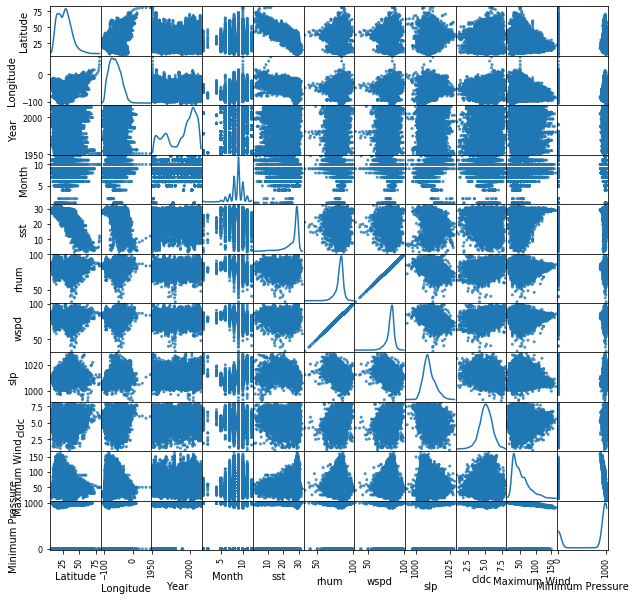

In [11]:
df = pd.concat([X_train, y_train_mw, y_train_mp], axis=1)
scatter_matrix(df, alpha=0.8, figsize=(10, 10), diagonal='kde')


In [12]:
# A princípio, não queremos que se faça alguma previsão com base no valor numérico do ano
# Além disso, a variável wspd está altamente correlacionada com a rhum, podendo ser mantida apenas a última
X_train = data_atl_merged.drop(['Year', 'wspd'], 1)

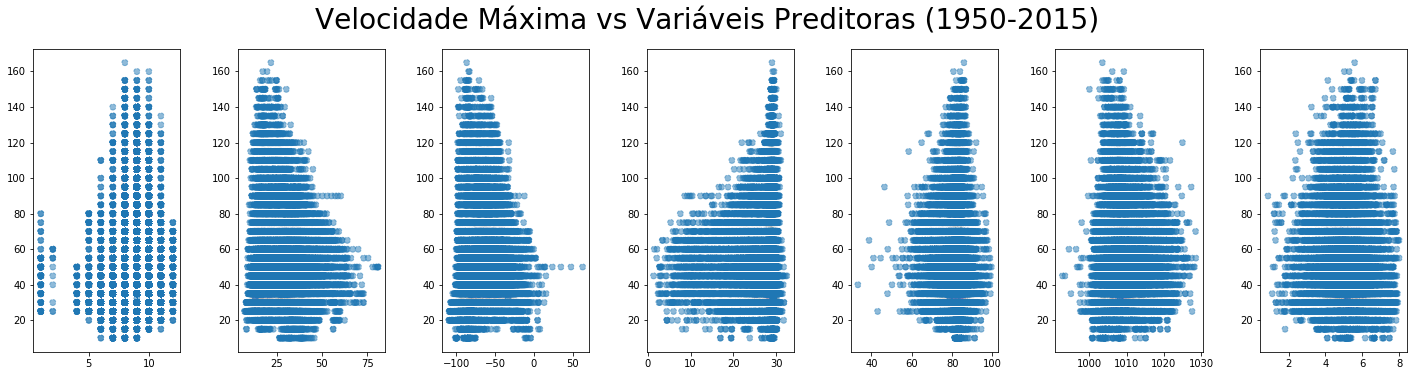

In [13]:
#   Mês      Latitude    Longitude    Temperatura, Umidade, Sea Level Pressure, Cloudiness]
# ['Month', 'Latitude', 'Longitude', 'sst',       'rhum',  'slp',              'cldc']

fig, ax = plt.subplots(1,7)#, figsize=(16,10))
fig.suptitle('Velocidade Máxima vs Variáveis Preditoras (1950-2015)', fontsize=28, y=1.06)

ax[0].scatter(X_train['Month'], X_train['Maximum Wind'], alpha = 0.5, ls = '--') #, label=r'$Furacões$ $=$ $0$')
ax[1].scatter(X_train['Latitude'], X_train['Maximum Wind'], alpha = 0.5, ls = '--') #, label=r'$Furacões$ $=$ $0$')
ax[2].scatter(X_train['Longitude'], X_train['Maximum Wind'], alpha = 0.5, ls = '--') #, label=r'$Furacões$ $=$ $0$')
ax[3].scatter(X_train['sst'], X_train['Maximum Wind'], alpha = 0.5, ls = '--') #, label=r'$Furacões$ $=$ $0$')
ax[4].scatter(X_train['rhum'], X_train['Maximum Wind'], alpha = 0.5, ls = '--') #, label=r'$Furacões$ $=$ $0$')
ax[5].scatter(X_train['slp'], X_train['Maximum Wind'], alpha = 0.5, ls = '--') #, label=r'$Furacões$ $=$ $0$')
ax[6].scatter(X_train['cldc'], X_train['Maximum Wind'], alpha = 0.5, ls = '--') #, label=r'$Furacões$ $=$ $0$')
#ax.plot([1850, 2015], [w0, w1], ls = '-.') #, label=r'$Furacões$ $=$ $0$')
'''
ax.tick_params(labelsize=24)
ax.set_title(f'Número de Furacões Anuais (1851-2015)', fontsize=24)
ax.set_xlabel(r'$Ano$', fontsize=16)
ax.set_ylabel(r'$Quantidade$', fontsize=16)
'''
#fig.legend(loc='best', fontsize=12);
fig.set_figheight(5)
fig.set_figwidth(20)
fig.tight_layout(pad=2.0)

In [14]:
X_train = data_atl_merged.drop(['ID', 'Name', 'Date', 'Time', 'Event', 'Status', 'Maximum Wind', 'Minimum Pressure', 'Date_c', 'Day', 'Latitude_c', 'Longitude_c', 'Duration', 'Year', 'wspd'], 1)
X_train.mean()


Latitude       27.466819
Longitude     -62.607058
Month           8.709729
sst            26.416134
rhum           81.284651
slp          1009.678574
cldc            5.137222
dtype: float64

Uma primeira tentativa de ajuste foi feito através da centralização das variáveis preditoras em relação à média, adicionando também termos polinomiais de segunda ordem. No entanto, os resultados do ajuste não mostraram ganhos significativos para o modelo de Regressão Linear Múltipla, e até prejudicaram modelos mais complexos, como Random Forest, Multi Layer Perceptron, entre outros utilizados mais a frente.

In [15]:
# Tentativa de ajuste através de transformação de variáveis e inclusão de termos polinomiais
X_train['Month_mod'] = (X_train['Month'] - 8.788781)
X_train['Latitude_mod'] = (X_train['Latitude'] - 17.943038)
X_train['Longitude_mod'] = (X_train['Longitude'] + 62.555538)
X_train['sst_mod'] = (X_train['sst'] - 28.888685)
X_train['rhum_mod'] = (X_train['rhum'] - 82.051702)
X_train['slp_mod'] = (X_train['slp'] - 1008.611661)
X_train['cldc_mod'] = (X_train['cldc'] - 5.223518)

X_train['Month_mod^2'] = X_train['Month_mod']**2
X_train['Latitude_mod^2'] = X_train['Latitude_mod']**2
X_train['Longitude_mod^2'] = X_train['Longitude_mod']**2
X_train['sst_mod^2'] = X_train['sst_mod']**2
X_train['rhum_mod^2'] = X_train['rhum_mod']**2
X_train['slp_mod^2'] = X_train['slp_mod']**2
X_train['cldc_mod^2'] = X_train['cldc_mod']**2

X_train = X_train.drop(['Month', 'Latitude', 'Longitude', 'sst', 'rhum', 'slp', 'cldc'], 1)

In [16]:
X_train.head()

,Month_mod,Latitude_mod,Longitude_mod,sst_mod,rhum_mod,slp_mod,cldc_mod,Month_mod^2,Latitude_mod^2,Longitude_mod^2,sst_mod^2,rhum_mod^2,slp_mod^2,cldc_mod^2
0,-7.788781,12.556962,4.555538,-16.517656,-9.594608,18.834394,-0.004262,60.665109,157.677295,20.752926,272.832952,92.056509,354.734396,0.000018
1,-7.788781,11.956962,5.755538,-12.670921,-1.627848,14.061317,0.533096,60.665109,142.968940,33.126218,160.552231,2.649888,197.720622,0.284192
2,-7.788781,11.056962,6.855538,-13.397561,-0.930112,14.540248,0.558956,60.665109,122.256409,46.998401,179.494647,0.865108,211.418806,0.312431
3,-7.788781,9.556962,7.755538,-6.620610,2.213059,10.713477,0.428324,60.665109,91.335523,60.148370,43.832480,4.897629,114.778588,0.183461
4,-7.788781,8.556962,8.055538,-6.551939,2.406915,10.694205,0.421888,60.665109,73.221599,64.891692,42.927902,5.793238,114.366028,0.177989


### Regressão Linear

In [17]:
X_train2 = sm.add_constant(X_train) #np.array(X_train).reshape(X_train.shape[0],1)
OLS_obj = OLS(y_train_mw, X_train2)
OLSModel = OLS_obj.fit()

r2_train = OLSModel.rsquared
#r2_test = 1 - ((OLSModel.predict(X_test2)-y_test)*(OLSModel.predict(X_test2)-y_test)).sum() / ((y_test.mean()-y_test)*(y_test.mean()-y_test)).sum()
print(f'R^2_train = {r2_train}')
#print(f'R^2_test  = {r2_test}')
print(f'Parâmetro_const  = {OLSModel.params[0]}')
print(f'Parâmetro_Month  = {OLSModel.params[1]}')
print(f'Parâmetro_Latitude  = {OLSModel.params[2]}')
print(f'Parâmetro_Longitude  = {OLSModel.params[3]}')
print(f'Parâmetro_sst  = {OLSModel.params[4]}')
print(f'Parâmetro_rhum  = {OLSModel.params[5]}')
print(f'Parâmetro_slp  = {OLSModel.params[6]}')
print(f'Parâmetro_cldc  = {OLSModel.params[7]}')

print(f'Parâmetro_Month^2  = {OLSModel.params[8]}')
print(f'Parâmetro_Latitude^2  = {OLSModel.params[9]}')
print(f'Parâmetro_Longitude^2  = {OLSModel.params[10]}')
print(f'Parâmetro_sst^2  = {OLSModel.params[11]}')
print(f'Parâmetro_rhum^2  = {OLSModel.params[12]}')
print(f'Parâmetro_slp^2  = {OLSModel.params[13]}')
print(f'Parâmetro_cldc^2  = {OLSModel.params[14]}')

R^2_train = 0.057796565423244184
Parâmetro_const  = 55.44314399378872
Parâmetro_Month  = 0.8453623447456429
Parâmetro_Latitude  = 0.34573620988221737
Parâmetro_Longitude  = -0.028915176195575265
Parâmetro_sst  = 0.02964116885735546
Parâmetro_rhum  = 0.09964668732076729
Parâmetro_slp  = 0.2891079532979721
Parâmetro_cldc  = -0.5559643046414529
Parâmetro_Month^2  = -0.4847374784647172
Parâmetro_Latitude^2  = -0.01772872078575176
Parâmetro_Longitude^2  = -0.008550227845669021
Parâmetro_sst^2  = 0.05156653294710069
Parâmetro_rhum^2  = 0.0022096690183924395
Parâmetro_slp^2  = -0.03379242085061315
Parâmetro_cldc^2  = -0.16931736469012737


In [18]:
X_train = data_atl_merged.drop(['ID', 'Name', 'Date', 'Time', 'Event', 'Status', 'Maximum Wind', 'Minimum Pressure', 'Date_c', 'Day', 'Latitude_c', 'Longitude_c', 'Duration', 'Year', 'wspd'], 1)
y_train_mw = data_atl_merged['Maximum Wind']
X_train, X_test, y_train_mw, y_test_mw = train_test_split(X_train, y_train_mw, random_state=1)
print(len(X_train))
X_train.head()


16789


,Latitude,Longitude,Month,sst,rhum,slp,cldc
10353,26.2,-78.2,8,28.981304,82.394811,1006.801278,4.477195
19374,14.5,-69.6,10,28.904502,82.054564,1010.190954,5.367316
12393,30.7,-86.3,7,28.347659,82.523253,1000.820020,6.652682
3373,40.9,-70.7,9,24.981041,77.434502,1012.284426,4.131097
21173,25.8,-42.5,9,28.643885,78.809962,1013.124650,4.610140


### Random Forest

Primeira tentativa de ajuste já nos parece promissor em relação aos demais.

In [19]:
#X_train, y_train_mw = make_regression(n_features=7, n_informative=2, random_state=0, shuffle=False)
regr = RandomForestRegressor(n_estimators=7, max_depth=20, random_state=0)
regr.fit(X_train, y_train_mw)
print(regr.score(X_train, y_train_mw))
print(regr.score(X_test, y_test_mw))


0.8272253680614361
0.43588010200277033


In [20]:
#X_train = data_atl_merged.drop(['ID', 'Name', 'Date', 'Time', 'Event', 'Status', 'Maximum Wind', 'Minimum Pressure', 'Date_c', 'Day', 'Latitude_c', 'Longitude_c', 'Duration', 'Year', 'wspd'], 1)
#X_train.head()

### Multi Layer Perceptron

In [21]:
#X_train, y_train_mw = make_regression(n_samples=200, random_state=1)
regr = MLPRegressor(hidden_layer_sizes=(100,2), random_state=1, max_iter=1000, solver='lbfgs').fit(X_train, y_train_mw)
#regr.predict(X_test[:2])
print(regr.score(X_train, y_train_mw))
print(regr.score(X_test, y_test_mw))


0.09773756387308707
0.0904819195883364


C:\Users\User\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


## Modelos com Separação em Conjuntos de Treino e Teste

Separamos os dados em conjuntos de treino e de teste. Deste modo, podemos ajustar o algoritmo utilizando os dados de treino, e tentar utilizar esses dados de teste para previsão de outros dados, inclusive futuros.

In [22]:
X_train = data_atl_merged.drop(['ID', 'Name', 'Date', 'Time', 'Event', 'Status', 'Maximum Wind', 'Minimum Pressure', 'Date_c', 'Day', 'Latitude_c', 'Longitude_c', 'Duration', 'Year', 'wspd'], 1)
y_train_mw = data_atl_merged['Maximum Wind']
#print(len(X_train))
#X_train.head()

X_train, X_test, y_train_mw, y_test_mw = train_test_split(X_train, y_train_mw, random_state=1)

### Regressão Linear

In [23]:
X_train2 = sm.add_constant(X_train) #np.array(X_train).reshape(X_train.shape[0],1)
X_test2 = sm.add_constant(X_test) #np.array(X_train).reshape(X_train.shape[0],1)
OLS_obj = OLS(y_train_mw, X_train2)
OLSModel = OLS_obj.fit()

r2_train = OLSModel.rsquared
r2_test = 1 - ((OLSModel.predict(X_test2)-y_test_mw)*(OLSModel.predict(X_test2)-y_test_mw)).sum() / ((y_test_mw.mean()-y_test_mw)*(y_test_mw.mean()-y_test_mw)).sum()
print(f'R^2_train = {r2_train}')
print(f'R^2_test  = {r2_test}')
'''
print(f'Parâmetro_const  = {OLSModel.params[0]}')
print(f'Parâmetro_Month  = {OLSModel.params[1]}')
print(f'Parâmetro_Latitude  = {OLSModel.params[2]}')
print(f'Parâmetro_Longitude  = {OLSModel.params[3]}')
print(f'Parâmetro_sst  = {OLSModel.params[4]}')
print(f'Parâmetro_rhum  = {OLSModel.params[5]}')
print(f'Parâmetro_slp  = {OLSModel.params[6]}')
print(f'Parâmetro_cldc  = {OLSModel.params[7]}')

print(f'Parâmetro_Month^2  = {OLSModel.params[8]}')
print(f'Parâmetro_Latitude^2  = {OLSModel.params[9]}')
print(f'Parâmetro_Longitude^2  = {OLSModel.params[10]}')
print(f'Parâmetro_sst^2  = {OLSModel.params[11]}')
print(f'Parâmetro_rhum^2  = {OLSModel.params[12]}')
print(f'Parâmetro_slp^2  = {OLSModel.params[13]}')
print(f'Parâmetro_cldc^2  = {OLSModel.params[14]}')
'''

R^2_train = 0.019806236602926464
R^2_test  = 0.01874952522766249


"\nprint(f'Parâmetro_const  = {OLSModel.params[0]}')\nprint(f'Parâmetro_Month  = {OLSModel.params[1]}')\nprint(f'Parâmetro_Latitude  = {OLSModel.params[2]}')\nprint(f'Parâmetro_Longitude  = {OLSModel.params[3]}')\nprint(f'Parâmetro_sst  = {OLSModel.params[4]}')\nprint(f'Parâmetro_rhum  = {OLSModel.params[5]}')\nprint(f'Parâmetro_slp  = {OLSModel.params[6]}')\nprint(f'Parâmetro_cldc  = {OLSModel.params[7]}')\n\nprint(f'Parâmetro_Month^2  = {OLSModel.params[8]}')\nprint(f'Parâmetro_Latitude^2  = {OLSModel.params[9]}')\nprint(f'Parâmetro_Longitude^2  = {OLSModel.params[10]}')\nprint(f'Parâmetro_sst^2  = {OLSModel.params[11]}')\nprint(f'Parâmetro_rhum^2  = {OLSModel.params[12]}')\nprint(f'Parâmetro_slp^2  = {OLSModel.params[13]}')\nprint(f'Parâmetro_cldc^2  = {OLSModel.params[14]}')\n"

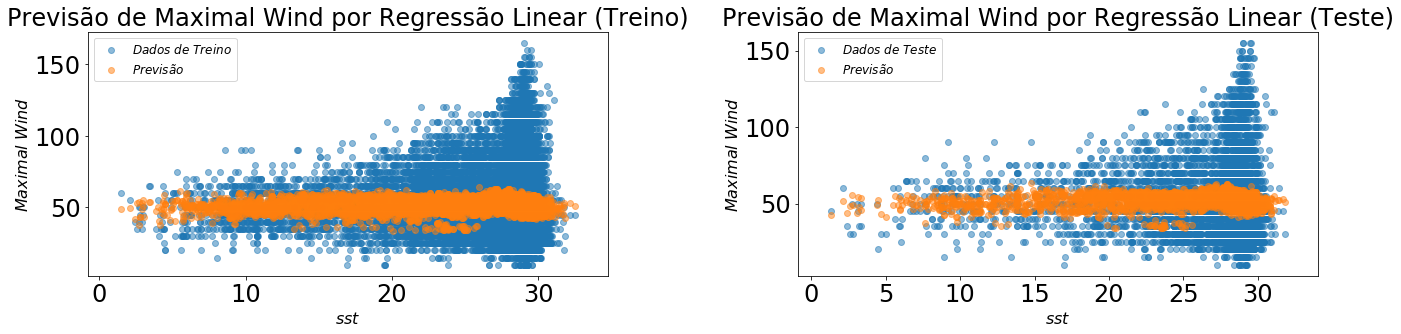

In [24]:
fig, ax = plt.subplots(1,2)#, figsize=(16,10))
#fig.suptitle('Velocidade Máxima vs Pressão Mínima (1851-2015)', fontsize=28, y=1.06)

ax[0].scatter(X_train['sst'], y_train_mw, alpha=0.5, label=r'$Dados$ $de$ $Treino$')
ax[0].scatter(X_train['sst'], OLSModel.predict(X_train2), alpha=0.5, label=r'$Previsão$')
ax[1].scatter(X_test['sst'], y_test_mw, alpha=0.5, label=r'$Dados$ $de$ $Teste$')
ax[1].scatter(X_test['sst'], OLSModel.predict(X_test2), alpha=0.5, label=r'$Previsão$')

ax[0].tick_params(labelsize=24)
ax[0].set_title(f'Previsão de Maximal Wind por Regressão Linear (Treino)', fontsize=24)
ax[0].set_xlabel(r'$sst$', fontsize=16)
ax[0].set_ylabel(r'$Maximal$ $Wind$', fontsize=16)
ax[0].legend(loc='best', fontsize=12);

ax[1].tick_params(labelsize=24)
ax[1].set_title(f'Previsão de Maximal Wind por Regressão Linear (Teste)', fontsize=24)
ax[1].set_xlabel(r'$sst$', fontsize=16)
ax[1].set_ylabel(r'$Maximal$ $Wind$', fontsize=16)
ax[1].legend(loc='best', fontsize=12);

fig.set_figheight(5)
fig.set_figwidth(20)
fig.tight_layout(pad=2.0)

### Random Forest

Pelos ajustes anteriores, vimos que esse algoritmo promove um bom ajuste nos dados. Um novo ajuste com aplicação de parâmetros melhor sintonizados com os dados é buscado pelo código abaixo.

In [25]:
# Parâmetros com bom ajuste para Random Forest: n_estimators = 50, max_depth = 75
for i in [25, 50, 75, 100, 125]:
    for j in [25, 50, 75, 100, 125]:
        regr_rf = RandomForestRegressor(n_estimators=i, max_depth=j, random_state=0, oob_score=True, bootstrap = True)
        regr_rf.fit(X_train, y_train_mw)
        print(f'\n n_estimators={i}, max_depth={j}')
        print(regr_rf.score(X_train, y_train_mw))
        print(regr_rf.score(X_test, y_test_mw))



 n_estimators=25, max_depth=25
0.9109127406378082
0.5049385543175804

 n_estimators=25, max_depth=50
0.9231191839999706
0.5083859136052509

 n_estimators=25, max_depth=75
0.9231191839999706
0.5083859136052509

 n_estimators=25, max_depth=100
0.9231191839999706
0.5083859136052509

 n_estimators=25, max_depth=125
0.9231191839999706
0.5083859136052509

 n_estimators=50, max_depth=25
0.9177312843005484
0.5190516352697632

 n_estimators=50, max_depth=50
0.9298001112559356
0.5227899508473133

 n_estimators=50, max_depth=75
0.9298001112559356
0.5227899508473133

 n_estimators=50, max_depth=100
0.9298001112559356
0.5227899508473133

 n_estimators=50, max_depth=125
0.9298001112559356
0.5227899508473133

 n_estimators=75, max_depth=25
0.9198026089627763
0.5227499387064152

 n_estimators=75, max_depth=50
0.9323017737677339
0.5256624725114608

 n_estimators=75, max_depth=75
0.9323017737677339
0.5256624725114608

 n_estimators=75, max_depth=100
0.9323017737677339
0.5256624725114608

 n_estimators=

O R2 Score obtido abaixo mostra o melhor ajuste do modelo quando tentamos prever a Velocidade Máxima Sustentada pelo algoritmo do Random Forest. O ajuste aos dados de treino ficam

In [26]:
regr_rf = RandomForestRegressor(n_estimators=50, max_depth=75, random_state=0, oob_score=True, bootstrap = True)
regr_rf.fit(X_train, y_train_mw)
print(regr_rf.score(X_train, y_train_mw))
print(regr_rf.score(X_test, y_test_mw))

0.9298001112559356
0.5227899508473133


In [27]:
X_train_red = X_train.drop(['sst', 'rhum', 'slp', 'cldc'], 1)
X_test_red = X_test.drop(['sst', 'rhum', 'slp', 'cldc'], 1)


Retirando os dados climáticos, observamos que o ajuste fica bem pior, mostrando a importância dos mesmos para a predição

In [28]:
regr_rf_red = RandomForestRegressor(n_estimators=50, max_depth=75, random_state=0, oob_score=True, bootstrap = True)
regr_rf_red.fit(X_train_red, y_train_mw)
print(regr_rf_red.score(X_train_red, y_train_mw))
print(regr_rf_red.score(X_test_red, y_test_mw))

0.8598571752407663
0.06143697855472363


In [29]:
X_train_red = X_train.drop(['Month', 'Latitude', 'Longitude'], 1)
X_test_red = X_test.drop(['Month', 'Latitude', 'Longitude'], 1)


In [30]:
regr_rf_red = RandomForestRegressor(n_estimators=50, max_depth=75, random_state=0, oob_score=True, bootstrap = True)
regr_rf_red.fit(X_train_red, y_train_mw)
print(regr_rf_red.score(X_train_red, y_train_mw))
print(regr_rf_red.score(X_test_red, y_test_mw))

0.9072010288584738
0.3833348196160016


In [31]:
#['Month', 'Latitude', 'Longitude', 'sst', 'rhum', 'slp', 'cldc']
X_train_red = X_train.drop(['Month'], 1)
X_test_red = X_test.drop(['Month'], 1)


In [32]:
regr_rf_red = RandomForestRegressor(n_estimators=50, max_depth=75, random_state=0, oob_score=True, bootstrap = True)
regr_rf_red.fit(X_train_red, y_train_mw)
print(regr_rf_red.score(X_train_red, y_train_mw))
print(regr_rf_red.score(X_test_red, y_test_mw))

0.92305378753988
0.4840455607978509


Ajuste da predição em relação à variável sst (temperatura mensal média)

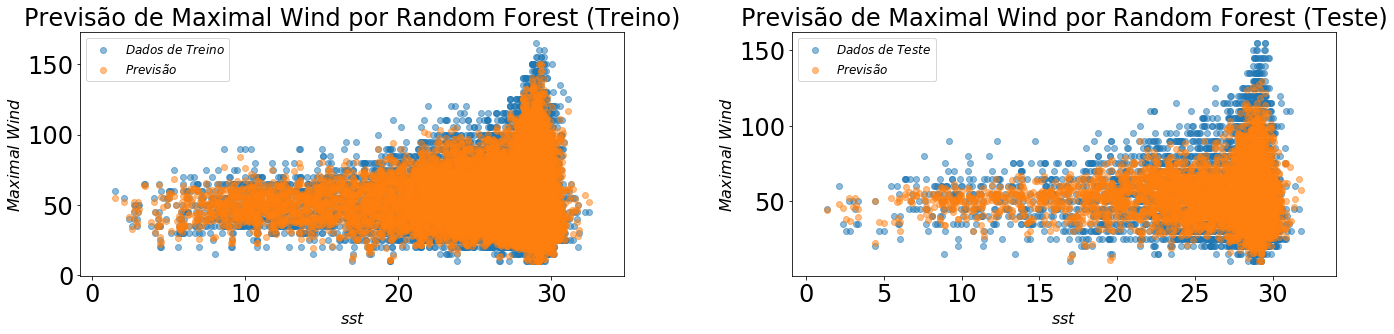

In [33]:
fig, ax = plt.subplots(1,2)#, figsize=(16,10))
#fig.suptitle('Velocidade Máxima vs Pressão Mínima (1851-2015)', fontsize=28, y=1.06)

ax[0].scatter(X_train['sst'], y_train_mw, alpha=0.5, label=r'$Dados$ $de$ $Treino$')
ax[0].scatter(X_train['sst'], regr_rf.predict(X_train), alpha=0.5, label=r'$Previsão$')
ax[1].scatter(X_test['sst'], y_test_mw, alpha=0.5, label=r'$Dados$ $de$ $Teste$')
ax[1].scatter(X_test['sst'], regr_rf.predict(X_test), alpha=0.5, label=r'$Previsão$')

ax[0].tick_params(labelsize=24)
ax[0].set_title(f'Previsão de Maximal Wind por Random Forest (Treino)', fontsize=24)
ax[0].set_xlabel(r'$sst$', fontsize=16)
ax[0].set_ylabel(r'$Maximal$ $Wind$', fontsize=16)
ax[0].legend(loc='best', fontsize=12);

ax[1].tick_params(labelsize=24)
ax[1].set_title(f'Previsão de Maximal Wind por Random Forest (Teste)', fontsize=24)
ax[1].set_xlabel(r'$sst$', fontsize=16)
ax[1].set_ylabel(r'$Maximal$ $Wind$', fontsize=16)
ax[1].legend(loc='best', fontsize=12);

fig.set_figheight(5)
fig.set_figwidth(20)
fig.tight_layout(pad=2.0)

### Demais Previsões com Random Forest (Melhor Ajuste)

Adicionando as variáveis Ano e Dia, conseguimos melhorar significativamente a capacidade de previsão do nosso modelo.
Se adicionarmos primeiramente apenas a variável Ano, percebemos que cada variável contribui um pouco para a melhoria da previsão.

In [34]:
data_train_sd = data_atl_merged.drop(['ID', 'Name', 'Date', 'Time', 'Event', 'Status', 'Maximum Wind', 'Minimum Pressure', 'Date_c', 'Latitude_c', 'Longitude_c', 'Duration', 'wspd', 'Day'], 1)
data_train_mw_sd = data_atl_merged['Maximum Wind']
#print(len(data_train))
#data_train.head()
data_train_sd, data_test_sd, data_train_mw_sd, data_test_mw_sd = train_test_split(data_train_sd, data_train_mw_sd, random_state=1)


In [35]:
regr_rf2_sd = RandomForestRegressor(n_estimators=50, max_depth=75, random_state=0, oob_score=True, bootstrap = True)
regr_rf2_sd.fit(data_train_sd, data_train_mw_sd)
print(regr_rf2_sd.score(data_train_sd, data_train_mw_sd))
print(regr_rf2_sd.score(data_test_sd, data_test_mw_sd))

0.9502630426894277
0.6609429559863541


In [36]:
data_train = data_atl_merged.drop(['ID', 'Name', 'Date', 'Time', 'Event', 'Status', 'Maximum Wind', 'Minimum Pressure', 'Date_c', 'Latitude_c', 'Longitude_c', 'Duration', 'wspd'], 1)
data_train_mw = data_atl_merged['Maximum Wind']
#print(len(data_train))
#data_train.head()
data_train, data_test, data_train_mw, data_test_mw = train_test_split(data_train, data_train_mw, random_state=1)

Ajuste fino dos parâmetros do Random Forest

In [37]:
for i in [25, 50, 75, 100, 125]:
    for j in [25, 50, 75, 100, 125]:
        regr_rf2 = RandomForestRegressor(n_estimators=i, max_depth=j, random_state=0, oob_score=True, bootstrap = True)
        regr_rf2.fit(data_train, data_train_mw)
        print(f'\n n_estimators={i}, max_depth={j}')
        print(regr_rf2.score(data_train, data_train_mw))
        print(regr_rf2.score(data_test, data_test_mw))


 n_estimators=25, max_depth=25
0.9572645628243289
0.7444676687346707

 n_estimators=25, max_depth=50
0.9582917968925032
0.7442935073801389

 n_estimators=25, max_depth=75
0.9582917968925032
0.7442935073801389

 n_estimators=25, max_depth=100
0.9582917968925032
0.7442935073801389

 n_estimators=25, max_depth=125
0.9582917968925032
0.7442935073801389

 n_estimators=50, max_depth=25
0.9617003376388379
0.7583441990969142

 n_estimators=50, max_depth=50
0.9629951225598821
0.7593567448937372

 n_estimators=50, max_depth=75
0.9629951225598821
0.7593567448937372

 n_estimators=50, max_depth=100
0.9629951225598821
0.7593567448937372

 n_estimators=50, max_depth=125
0.9629951225598821
0.7593567448937372

 n_estimators=75, max_depth=25
0.9637876668338223
0.7615184996888411

 n_estimators=75, max_depth=50
0.9651229272756359
0.7623946732426374

 n_estimators=75, max_depth=75
0.9651229272756359
0.7623946732426374

 n_estimators=75, max_depth=100
0.9651229272756359
0.7623946732426374

 n_estimators=

Melhor ajuste para Previsão de Maximal Wind

In [38]:
regr_rf2 = RandomForestRegressor(n_estimators=50, max_depth=50, random_state=0, oob_score=True, bootstrap = True)
regr_rf2.fit(data_train, data_train_mw)
print(regr_rf2.score(data_train, data_train_mw))
print(regr_rf2.score(data_test, data_test_mw))

0.9629951225598821
0.7593567448937372


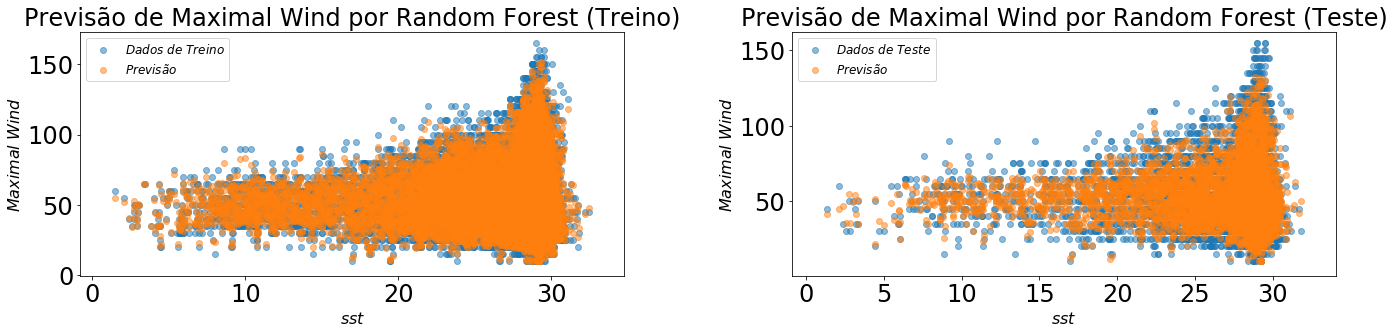

In [39]:
fig, ax = plt.subplots(1,2)#, figsize=(16,10))
#fig.suptitle('Velocidade Máxima vs Pressão Mínima (1851-2015)', fontsize=28, y=1.06)

ax[0].scatter(data_train['sst'], data_train_mw, alpha=0.5, label=r'$Dados$ $de$ $Treino$')
ax[0].scatter(data_train['sst'], regr_rf2.predict(data_train), alpha=0.5, label=r'$Previsão$')
ax[1].scatter(data_test['sst'], data_test_mw, alpha=0.5, label=r'$Dados$ $de$ $Teste$')
ax[1].scatter(data_test['sst'], regr_rf2.predict(data_test), alpha=0.5, label=r'$Previsão$')

ax[0].tick_params(labelsize=24)
ax[0].set_title(f'Previsão de Maximal Wind por Random Forest (Treino)', fontsize=24)
ax[0].set_xlabel(r'$sst$', fontsize=16)
ax[0].set_ylabel(r'$Maximal$ $Wind$', fontsize=16)
ax[0].legend(loc='best', fontsize=12);

ax[1].tick_params(labelsize=24)
ax[1].set_title(f'Previsão de Maximal Wind por Random Forest (Teste)', fontsize=24)
ax[1].set_xlabel(r'$sst$', fontsize=16)
ax[1].set_ylabel(r'$Maximal$ $Wind$', fontsize=16)
ax[1].legend(loc='best', fontsize=12);

fig.set_figheight(5)
fig.set_figwidth(20)
fig.tight_layout(pad=2.0)

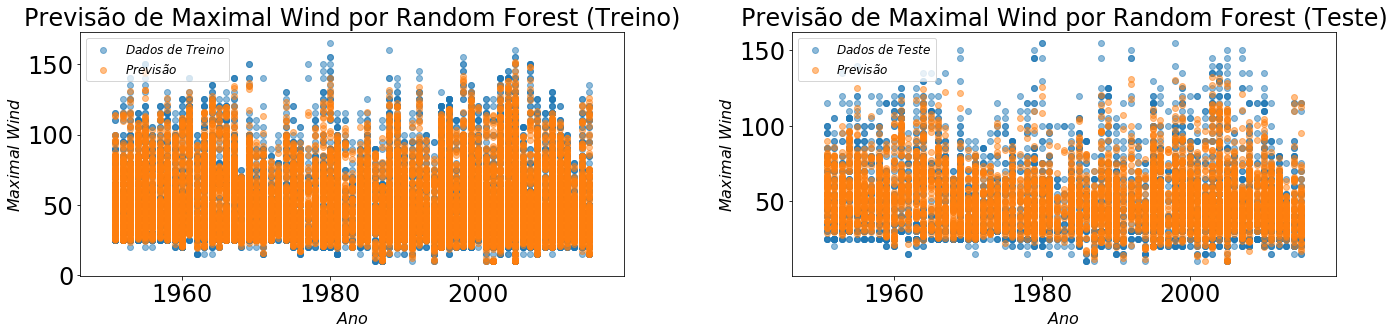

In [40]:
fig, ax = plt.subplots(1,2)#, figsize=(16,10))
#fig.suptitle('Velocidade Máxima vs Pressão Mínima (1851-2015)', fontsize=28, y=1.06)
data_concat_train = pd.concat([data_train, data_train_mw], axis=1)
data_concat_test = pd.concat([data_test, data_test_mw], axis=1)

ax[0].scatter(data_concat_train['Year'], data_concat_train['Maximum Wind'], alpha=0.5, label=r'$Dados$ $de$ $Treino$')
ax[0].scatter(data_concat_train['Year'], regr_rf2.predict(data_train), alpha=0.5, label=r'$Previsão$')
ax[1].scatter(data_concat_test['Year'], data_concat_test['Maximum Wind'], alpha=0.5, label=r'$Dados$ $de$ $Teste$')
ax[1].scatter(data_concat_test['Year'], regr_rf2.predict(data_test), alpha=0.5, label=r'$Previsão$')

ax[0].tick_params(labelsize=24)
ax[0].set_title(f'Previsão de Maximal Wind por Random Forest (Treino)', fontsize=24)
ax[0].set_xlabel(r'$Ano$', fontsize=16)
ax[0].set_ylabel(r'$Maximal$ $Wind$', fontsize=16)
ax[0].legend(loc='best', fontsize=12);

ax[1].tick_params(labelsize=24)
ax[1].set_title(f'Previsão de Maximal Wind por Random Forest (Teste)', fontsize=24)
ax[1].set_xlabel(r'$Ano$', fontsize=16)
ax[1].set_ylabel(r'$Maximal$ $Wind$', fontsize=16)
ax[1].legend(loc='best', fontsize=12);

fig.set_figheight(5)
fig.set_figwidth(20)
fig.tight_layout(pad=2.0)

### Previsão da duração dos eventos de Furacão

In [41]:
data_train2 = data_atl_merged.drop(['ID', 'Name', 'Date', 'Time', 'Event', 'Status', 'Maximum Wind', 'Minimum Pressure', 'Date_c', 'Latitude_c', 'Longitude_c', 'Duration', 'wspd'], 1)
#data_train_mw = data_atl_merged['Maximum Wind']
data_train_dur = data_atl_merged['Duration']
#print(len(data_train))
#data_train.head()
data_train2, data_test2, data_train_dur, data_test_dur = train_test_split(data_train2, data_train_dur, random_state=1)


Abaixo, faremos também a previsão da duração de um Furacão. O ajuste fica bem preciso, como se pode ver pelo R2 Score

In [42]:
regr_rf3 = RandomForestRegressor(n_estimators=50, max_depth=75, random_state=0, oob_score=True, bootstrap = True)
regr_rf3.fit(data_train2, data_train_dur)
print(regr_rf3.score(data_train2, data_train_dur))
print(regr_rf3.score(data_test2, data_test_dur))

0.9883397102866288
0.9289716458290775


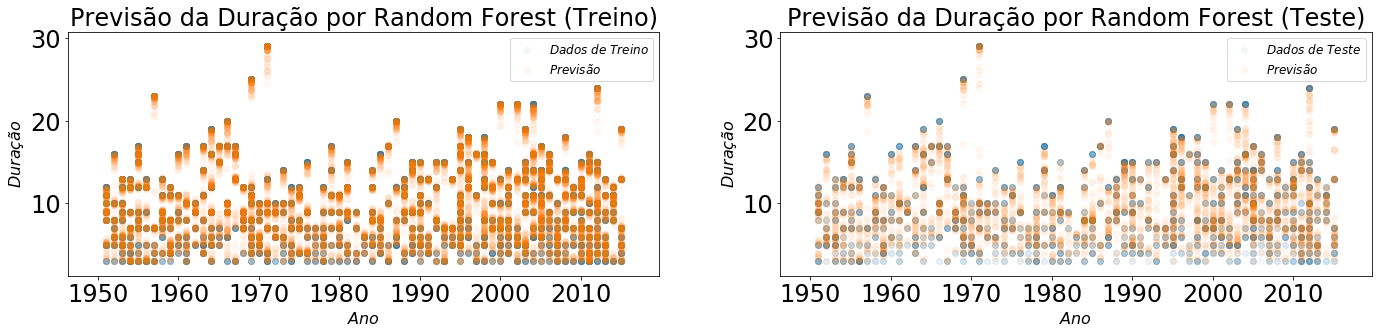

In [43]:
fig, ax = plt.subplots(1,2)#, figsize=(16,10))
#fig.suptitle('Velocidade Máxima vs Pressão Mínima (1851-2015)', fontsize=28, y=1.06)
data_concat_train = pd.concat([data_train, data_train_mw, data_train_dur], axis=1)
data_concat_test = pd.concat([data_test, data_test_mw, data_test_dur], axis=1)

ax[0].scatter(data_concat_train['Year'], data_concat_train['Duration'], alpha=0.05, label=r'$Dados$ $de$ $Treino$')
ax[0].scatter(data_concat_train['Year'], regr_rf3.predict(data_train2), alpha=0.05, label=r'$Previsão$')
ax[1].scatter(data_concat_test['Year'], data_concat_test['Duration'], alpha=0.05, label=r'$Dados$ $de$ $Teste$')
ax[1].scatter(data_concat_test['Year'], regr_rf3.predict(data_test2), alpha=0.05, label=r'$Previsão$')

ax[0].tick_params(labelsize=24)
ax[0].set_title(f'Previsão da Duração por Random Forest (Treino)', fontsize=24)
ax[0].set_xlabel(r'$Ano$', fontsize=16)
ax[0].set_ylabel(r'$Duração$', fontsize=16)
ax[0].legend(loc='best', fontsize=12);

ax[1].tick_params(labelsize=24)
ax[1].set_title(f'Previsão da Duração por Random Forest (Teste)', fontsize=24)
ax[1].set_xlabel(r'$Ano$', fontsize=16)
ax[1].set_ylabel(r'$Duração$', fontsize=16)
ax[1].legend(loc='best', fontsize=12);

fig.set_figheight(5)
fig.set_figwidth(20)
fig.tight_layout(pad=2.0)

### Multi Layer Perceptron

In [44]:
regr_mlp = MLPRegressor(hidden_layer_sizes=(100,2), random_state=1, max_iter=1000, solver='lbfgs', activation='relu').fit(X_train, y_train_mw)
#regr.predict(X_test[:2])
print(regr_mlp.score(X_train, y_train_mw))
print(regr_mlp.score(X_test, y_test_mw))

0.09773756387308707
0.0904819195883364


C:\Users\User\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


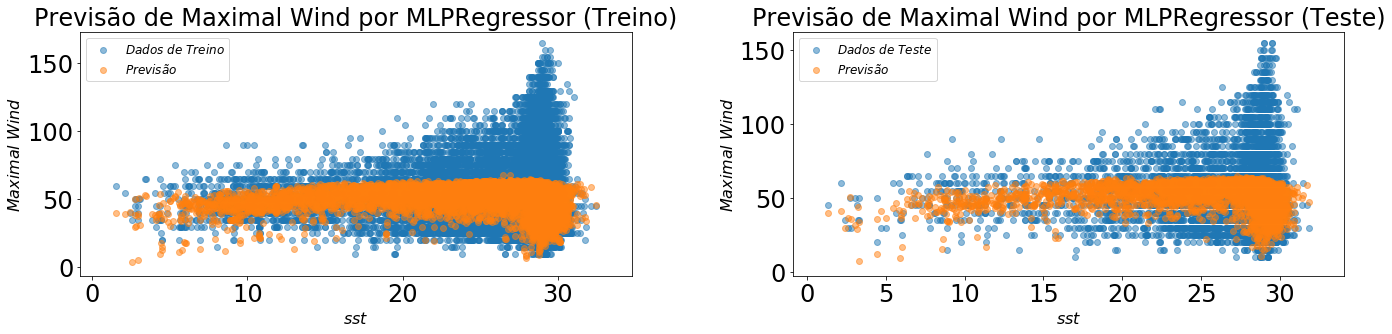

In [45]:
fig, ax = plt.subplots(1,2)#, figsize=(16,10))
#fig.suptitle('Velocidade Máxima vs Pressão Mínima (1851-2015)', fontsize=28, y=1.06)

ax[0].scatter(X_train['sst'], y_train_mw, alpha=0.5, label=r'$Dados$ $de$ $Treino$')
ax[0].scatter(X_train['sst'], regr_mlp.predict(X_train), alpha=0.5, label=r'$Previsão$')
ax[1].scatter(X_test['sst'], y_test_mw, alpha=0.5, label=r'$Dados$ $de$ $Teste$')
ax[1].scatter(X_test['sst'], regr_mlp.predict(X_test), alpha=0.5, label=r'$Previsão$')

ax[0].tick_params(labelsize=24)
ax[0].set_title(f'Previsão de Maximal Wind por MLPRegressor (Treino)', fontsize=24)
ax[0].set_xlabel(r'$sst$', fontsize=16)
ax[0].set_ylabel(r'$Maximal$ $Wind$', fontsize=16)
ax[0].legend(loc='best', fontsize=12);

ax[1].tick_params(labelsize=24)
ax[1].set_title(f'Previsão de Maximal Wind por MLPRegressor (Teste)', fontsize=24)
ax[1].set_xlabel(r'$sst$', fontsize=16)
ax[1].set_ylabel(r'$Maximal$ $Wind$', fontsize=16)
ax[1].legend(loc='best', fontsize=12);

fig.set_figheight(5)
fig.set_figwidth(20)
fig.tight_layout(pad=2.0)

### Support Vector Machine

In [46]:
regr_svr = svm.SVR()
regr_svr.fit(X_train, y_train_mw)
print(regr_svr.score(X_train, y_train_mw))
print(regr_svr.score(X_test, y_test_mw))

-0.06514630260669341
-0.058505019763586796


### Modelos com Escala Padronizada

In [47]:
# Padronização da Escala
scaler = StandardScaler()  # doctest: +SKIP
scaler.fit(X_train)  # doctest: +SKIP
X_train_std = scaler.transform(X_train)  # doctest: +SKIP
X_test_std = scaler.transform(X_test)

In [48]:
regr_svr_std = svm.SVR()
regr_svr_std.fit(X_train_std, y_train_mw)
print(regr_svr_std.score(X_train_std, y_train_mw))
print(regr_svr_std.score(X_test_std, y_test_mw))

0.07772469466765619
0.07604328404370786


In [49]:
regr_mlp_std = MLPRegressor(hidden_layer_sizes=(100,2), random_state=1, max_iter=1000, solver='lbfgs', activation='relu').fit(X_train, y_train_mw)
#regr.predict(X_test[:2])
print(regr_mlp_std.score(X_train_std, y_train_mw))
print(regr_mlp_std.score(X_test_std, y_test_mw))

-4.130686549364527
-4.119546349188243


C:\Users\User\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [50]:
regr_rf_std= RandomForestRegressor(n_estimators=50, max_depth=75, random_state=0, oob_score=True, bootstrap = True)
regr_rf_std.fit(X_train_std, y_train_mw)
print(regr_rf_std.score(X_train_std, y_train_mw))
print(regr_rf_std.score(X_test_std, y_test_mw))

0.9298162379440262
0.5220914993160997
